## Flights - Applied Machine Learning 1st Assignment | Fall Semester 2019-2020
***
> Nikolaos Fragkomanolis AM: 8160142 <br />
> Athens University of Economics and Business 16/10/2019 <br />

At first, we need to do the necessary steps which will give such format to our data in order to edit and show the results that we want. We import the necessary libs - without which we cannot handle anything! 

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

We use the `read_csv` method of pandas to open our file and afterwards we present a sample of 10 records in order to have a first sight of the data, to what each column refers and understand their meaning. 

In [31]:
data_filename = '515364771_T_ONTIME_REPORTING.csv'
data = pd.read_csv(data_filename)
data.sample(10)

,FL_DATE,TAIL_NUM,CARRIER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 19
1019304,2018-02-25,N904EV,OO,TUS,"Tucson, AZ",DEN,"Denver, CO",657.0,-3.0,858.0,-8.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5739785,2018-10-17,N599NN,OH,DAY,"Dayton, OH",CLT,"Charlotte, NC",653.0,-10.0,822.0,-27.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6863410,2018-12-13,N316FR,F9,IAH,"Houston, TX",DEN,"Denver, CO",510.0,-4.0,633.0,-22.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1301548,2018-03-11,N547US,DL,LAX,"Los Angeles, CA",OGG,"Kahului, HI",1525.0,5.0,1824.0,6.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6546959,2018-11-27,N355NW,DL,ATL,"Atlanta, GA",DFW,"Dallas/Fort Worth, TX",737.0,-1.0,915.0,10.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5692331,2018-10-14,N339DN,DL,DTW,"Detroit, MI",LAX,"Los Angeles, CA",1748.0,2.0,2001.0,17.0,0.0,NaN,0.0,0.0,0.0,17.0,0.0,0.0,NaN
5596267,2018-10-09,N262PS,OH,EVV,"Evansville, IN",CLT,"Charlotte, NC",1102.0,-15.0,1354.0,-12.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1353639,2018-03-14,N481WN,WN,MCI,"Kansas City, MO",LGA,"New York, NY",1204.0,-1.0,1606.0,16.0,0.0,NaN,0.0,0.0,0.0,16.0,0.0,0.0,NaN
2050657,2018-04-18,N566WN,WN,ATL,"Atlanta, GA",IND,"Indianapolis, IN",839.0,-1.0,1008.0,-7.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
453178,2018-01-25,N80343,YV,IAH,"Houston, TX",DFW,"Dallas/Fort Worth, TX",739.0,4.0,842.0,-11.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## Question 1
### The first question presents:
- a **'misery index'**<a id='misery index'></a> for airports, which means a descending order of the airports based on the probability that a passenger leaving from every different airport have a delay
- the **average** and **median** delay for each airport
- a **combination** of the two previous bullets in the same results

### Cleaning
Before we start, we need to "clean" our data and exclude the airports which have a very limited number of flights because we are not interested in them. To do this, we need to calculate the total flights of each airport.

In [32]:
total_fl = pd.DataFrame(data.ORIGIN.value_counts())
total_fl = total_fl.reset_index()
total_fl.columns = ['ORIGIN', 'NUM_OF_FLIGHTS']
total_fl.sample(10)

,ORIGIN,NUM_OF_FLIGHTS
138,MLI,5048
190,MOT,2560
314,HIB,625
4,CLT,233317
119,SHV,6694
187,PHF,2669
301,RKS,680
89,ALB,12360
133,ECP,5537
50,JAX,31340


We want to exclude the airports in the lowest 1% percentile in the total number of flights.  

In [33]:
outliers = total_fl.loc[total_fl.NUM_OF_FLIGHTS < total_fl.NUM_OF_FLIGHTS.quantile(0.01)]
outliers

,ORIGIN,NUM_OF_FLIGHTS
354,CYS,58
355,IFP,45
356,ART,25
357,YNG,2


So now we are aware of the airports which need to be excluded. Time to remove them!

In [34]:
print(len(data))

7213446


In [35]:
clean_data = data.loc[~data['ORIGIN'].isin(outliers.ORIGIN)]
print(len(clean_data))

7213316


### How possible is it to have a delay?
At this point, we want to calculate how possible it is that a passenger leaving from a given airport face a delay. To do this, we need to find the total number of delayed flights for each airport, after we create a new dataframe which includes all the delayed flights.

In [36]:
del_airp = clean_data[(clean_data.DEP_DELAY > 0.0)]
print(len(del_airp))
del_airp.head(3)

2449165


,FL_DATE,TAIL_NUM,CARRIER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 19
1,2018-01-01,N8891A,9E,MSP,"Minneapolis, MN",GFK,"Grand Forks, ND",1124.0,9.0,1234.0,-11.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,N293PQ,9E,DTW,"Detroit, MI",SAT,"San Antonio, TX",2022.0,4.0,2232.0,-50.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,N295PQ,9E,BOS,"Boston, MA",CVG,"Cincinnati, OH",1349.0,104.0,1613.0,94.0,0.0,NaN,0.0,79.0,0.0,0.0,0.0,15.0,NaN


In [37]:
num_del_airp = pd.DataFrame(del_airp.ORIGIN.value_counts())
num_del_airp = num_del_airp.reset_index()
num_del_airp.columns = ["ORIGIN", "NUM_OF_DEL_FLIGHTS"]
print(len(num_del_airp))
num_del_airp.head()

354


,ORIGIN,NUM_OF_DEL_FLIGHTS
0,ATL,141182
1,ORD,112855
2,DFW,100994
3,DEN,88915
4,CLT,88139


We are ready to calculate the probability we are looking for. In order to make our life easier, we join the two data-frames. And, we have our **'misery index'**.

In [38]:
prob_del_airp = pd.merge(total_fl, num_del_airp, on = "ORIGIN")
prob_del_airp['DELAY_PROBABILITY'] = (prob_del_airp.NUM_OF_DEL_FLIGHTS/prob_del_airp.NUM_OF_FLIGHTS)*100
prob_del_airp = prob_del_airp.sort_values(by='DELAY_PROBABILITY', ascending=False)
prob_del_airp.head(3)

,ORIGIN,NUM_OF_FLIGHTS,NUM_OF_DEL_FLIGHTS,DELAY_PROBABILITY
344,OGD,126,83,65.873016
282,SCK,747,486,65.060241
25,MDW,87095,51131,58.707159


### Average and Median
Going back to our data, we want to present the average and median delay for each airport.

In [39]:
avg_del_airp = del_airp.groupby('ORIGIN', as_index=False)['DEP_DELAY'].mean()
median_del_airp = del_airp.groupby('ORIGIN', as_index=False)['DEP_DELAY'].median()
stats_del_airp = pd.merge(avg_del_airp, median_del_airp, on = "ORIGIN")
stats_del_airp.rename(columns={'DEP_DELAY_x': 'AVG_DELAY', 'DEP_DELAY_y': 'MEDIAN_DELAY'}, inplace = True)
stats_del_airp.sort_values(by ='AVG_DELAY', ascending=False, inplace=True)
stats_del_airp.head()

,ORIGIN,AVG_DELAY,MEDIAN_DELAY
98,DVL,138.419048,43.0
266,PPG,106.448276,19.0
177,JMS,104.857895,31.0
73,CMX,99.817308,37.5
282,RHI,96.752294,32.0


### Enriching the airport misery index
At the end of Question 1, we are going to **combine** the results we found; the probability that a passenger will face a delay at a given airport, the average delay and the median, all in descending order according to the delay possibility.

In [40]:
stats_del_airp['DELAY_PROBABILITY'] = prob_del_airp['DELAY_PROBABILITY']
stats_del_airp = stats_del_airp.sort_values(by='DELAY_PROBABILITY', ascending=False)
stats_del_airp.head(10)

,ORIGIN,AVG_DELAY,MEDIAN_DELAY,DELAY_PROBABILITY
344,UIN,69.818182,30.0,65.873016
282,RHI,96.752294,32.0,65.060241
25,AZA,37.712859,18.0,58.707159
349,WRG,30.154412,17.0,58.426966
28,BET,25.165680,11.0,57.108247
34,BIL,53.572539,21.0,54.352449
347,VLD,47.228000,14.5,50.450450
342,TYR,40.613065,16.0,49.275362
271,PSM,61.761194,26.5,48.122867
345,USA,57.516393,24.0,47.540984


## Question 2
Question 2 covers almost the same results with the first one, but this time focusing on the **airlines**. We now want to analyze the grade on which the airline companies make their passengers' life dificult due to delayed flights.

### How possible is it to have a delay?
We are going to follow almost the same path in order to find the delayed flights. For this reason, we count the total amount of flights that each airline had.

In [41]:
total_airl = pd.DataFrame(data.CARRIER.value_counts())
total_airl.reset_index(inplace = True)
total_airl.columns = ['CARRIER', 'TOTAL_FLIGHTS']
total_airl.head(3)

,CARRIER,TOTAL_FLIGHTS
0,WN,1352552
1,DL,949283
2,AA,916818


In order to calculate the probability we are looking for, we need to find the total amount of **delayed** flights per airline. Hence, we add a new column TOTAL_DEL_FLIGHTS. 

In [42]:
del_airl = data[(data.DEP_DELAY > 0.0)]
total_del_airl = pd.DataFrame(del_airl.CARRIER.value_counts())
total_del_airl.reset_index(inplace=True)
total_del_airl.columns = ['CARRIER', 'TOTAL_DEL_FLIGHTS']
prob_del_airl = pd.merge(total_airl, total_del_airl, on = "CARRIER")
prob_del_airl.head(3)

,CARRIER,TOTAL_FLIGHTS,TOTAL_DEL_FLIGHTS
0,WN,1352552,662363
1,DL,949283,286165
2,AA,916818,317751


Now, we have all the information needed in order to count the **probability**.

In [43]:
prob_del_airl['PROBABILITY_OF_DEL'] = (prob_del_airl.TOTAL_DEL_FLIGHTS/prob_del_airl.TOTAL_FLIGHTS)*100
prob_del_airl.sort_values(by='PROBABILITY_OF_DEL', ascending = False, inplace = True)
prob_del_airl

,CARRIER,TOTAL_FLIGHTS,TOTAL_DEL_FLIGHTS,PROBABILITY_OF_DEL
0,WN,1352552,662363,48.971352
14,F9,120035,53321,44.421210
6,B6,305010,125011,40.985869
8,OH,278457,100247,36.000891
2,AA,916818,317751,34.658024
15,G4,96221,32886,34.177570
17,VX,17670,5382,30.458404
1,DL,949283,286165,30.145383
4,UA,621565,185249,29.803641
13,NK,176178,51119,29.015541


In order to have a better understanding of the results we replace the content of column CARRIER with the full name of each airline. For this reason, we open the file that contains these names, we do the operations needed and provide our probability dataframe with the full names.

In [44]:
airl_names_fn = 'L_UNIQUE_CARRIERS.csv_'
airl_names = pd.read_csv(airl_names_fn)
airl_names_2018 = pd.DataFrame(airl_names[(airl_names.Code.isin(prob_del_airl.CARRIER))])
airl_names_2018.columns = ['CARRIER', 'AIRLINE']
code_to_full_names = {'9E': 'Endeavor Air Inc.',
                    'AA': 'American Airlines Inc.',
                    'AS': 'Alaska Airlines Inc.',
                    'B6': 'JetBlue Airways',
                    'DL': 'Delta Air Lines Inc.',
                    'EV': 'ExpressJet Airlines LLC',
                    'F9': 'Frontier Airlines Inc.',
                    'G4': 'Allegiant Air',
                    'HA': 'Hawaiian Airlines Inc.',
                    'MQ': 'Envoy Air',
                    'NK': 'Spirit Air Lines',
                    'OH': 'PSA Airlines Inc.',
                    'OO': 'SkyWest Airlines Inc.',
                    'UA': 'United Air Lines Inc.',
                    'VX': 'Virgin America',
                    'WN': 'Southwest Airlines Co.',
                    'YV': 'Mesa Airlines Inc.',
                    'YX': 'Republic Airline'}
prob_del_airl['CARRIER'] = prob_del_airl['CARRIER'].map(code_to_full_names)
prob_del_airl

,CARRIER,TOTAL_FLIGHTS,TOTAL_DEL_FLIGHTS,PROBABILITY_OF_DEL
0,Southwest Airlines Co.,1352552,662363,48.971352
14,Frontier Airlines Inc.,120035,53321,44.421210
6,JetBlue Airways,305010,125011,40.985869
8,PSA Airlines Inc.,278457,100247,36.000891
2,American Airlines Inc.,916818,317751,34.658024
15,Allegiant Air,96221,32886,34.177570
17,Virgin America,17670,5382,30.458404
1,Delta Air Lines Inc.,949283,286165,30.145383
4,United Air Lines Inc.,621565,185249,29.803641
13,Spirit Air Lines,176178,51119,29.015541


### Average and Median
Alomst the same precedure we followed in Question 1 to find the **average** and **median** of the airports.

In [45]:
avg_del_airl = del_airl.groupby('CARRIER', as_index=False)['DEP_DELAY'].mean()
median_del_airl = del_airl.groupby('CARRIER', as_index=False)['DEP_DELAY'].median()
stats_del_airl = pd.merge(avg_del_airl, median_del_airl, on = "CARRIER")
stats_del_airl.rename(columns={'DEP_DELAY_x': 'AVG_DELAY', 'DEP_DELAY_y': 'MEDIAN_DELAY'}, inplace = True)
stats_del_airl.sort_values(by='AVG_DELAY', ascending=False, inplace=True)
stats_del_airl['CARRIER'] = stats_del_airl['CARRIER'].map(code_to_full_names)
stats_del_airl

,CARRIER,AVG_DELAY,MEDIAN_DELAY
5,ExpressJet Airlines LLC,61.865041,31.0
12,SkyWest Airlines Inc.,54.693784,24.0
0,Endeavor Air Inc.,53.945690,25.0
16,Mesa Airlines Inc.,51.562570,23.0
6,Frontier Airlines Inc.,50.856173,25.0
7,Allegiant Air,49.588548,22.0
3,JetBlue Airways,47.006303,24.0
17,Republic Airline,46.784504,25.0
10,Spirit Air Lines,46.655881,19.0
13,United Air Lines Inc.,45.336768,20.0


### Enriching the airline misery index
Same with question 1, we combine the results we found; the probability, the average and the median delay per airline. 

In [46]:
stats_del_airl['DELAY_PROBABILITY'] = prob_del_airl['PROBABILITY_OF_DEL']
stats_del_airl = stats_del_airl.sort_values(by='DELAY_PROBABILITY', ascending=False)
stats_del_airl

,CARRIER,AVG_DELAY,MEDIAN_DELAY,DELAY_PROBABILITY
0,Endeavor Air Inc.,53.945690,25.0,48.971352
14,Virgin America,34.926979,18.0,44.421210
6,Frontier Airlines Inc.,50.856173,25.0,40.985869
8,Hawaiian Airlines Inc.,19.220196,7.0,36.000891
2,Alaska Airlines Inc.,28.812374,14.0,34.658024
15,Southwest Airlines Co.,25.382091,12.0,34.177570
17,Republic Airline,46.784504,25.0,30.458404
1,American Airlines Inc.,37.123392,16.0,30.145383
4,Delta Air Lines Inc.,33.571667,13.0,29.803641
13,United Air Lines Inc.,45.336768,20.0,29.015541


## Question 3
In this question we are going to show a histogram that expresses the distribution of departures for airports.

We divide our x-scale logarithmically in order to show a reasonable distribution of the departures. Otherwise, a histogram would be difficult to be read and explained. Each bin defines specific spaces which express the number of flights, while the y-axis shows the number of airlines that have a total number of flights within the space of the bin.

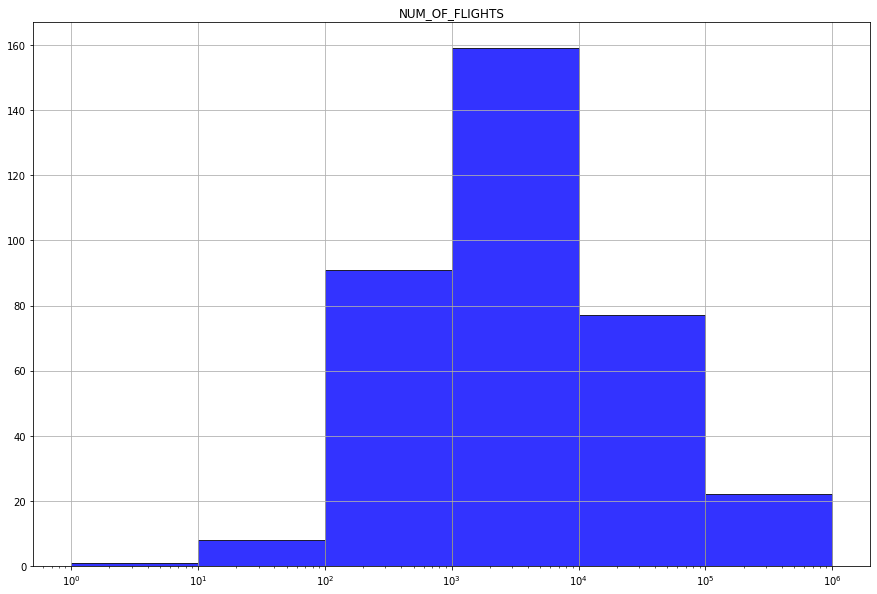

In [47]:
hist = total_fl.hist(bins=np.logspace(0, 6, num=7),
                    color='blue', edgecolor='black',
                     alpha = 0.8, figsize=(15,10))
plt.xscale('log')

## Question 4
This question provides the temporal distribution of delays. We are going to create **a plot that combines the total number of flights and the number of delayed flights per month of year**.

We first need to calculate the total number of flights per month of year.

In [48]:
temp_monthly_fl = pd.DataFrame(pd.to_datetime(data['FL_DATE']))
monthly_fl = pd.DataFrame(temp_monthly_fl['FL_DATE'].dt.month.value_counts())
monthly_fl.sort_index(inplace = True)
monthly_fl

,FL_DATE
1,570118
2,520731
3,611987
4,596046
5,616529
6,626193
7,645299
8,644673
9,585749
10,616101


Then, we need to calculate the number of delayed flights per month of year. We use `del_airl` that we extracted in question 2 that contains all the delayed flights.

In [49]:
temp_del_monthly_fl = pd.DataFrame(pd.to_datetime(del_airl['FL_DATE']))
del_monthly_fl = pd.DataFrame(temp_del_monthly_fl['FL_DATE'].dt.month.value_counts())
del_monthly_fl.sort_index(inplace=True)
del_monthly_fl

,FL_DATE
1,183723
2,174962
3,199775
4,193204
5,215382
6,238353
7,246392
8,239323
9,167257
10,187187


Now we can create the plot that shows the temporal distribution of delays.

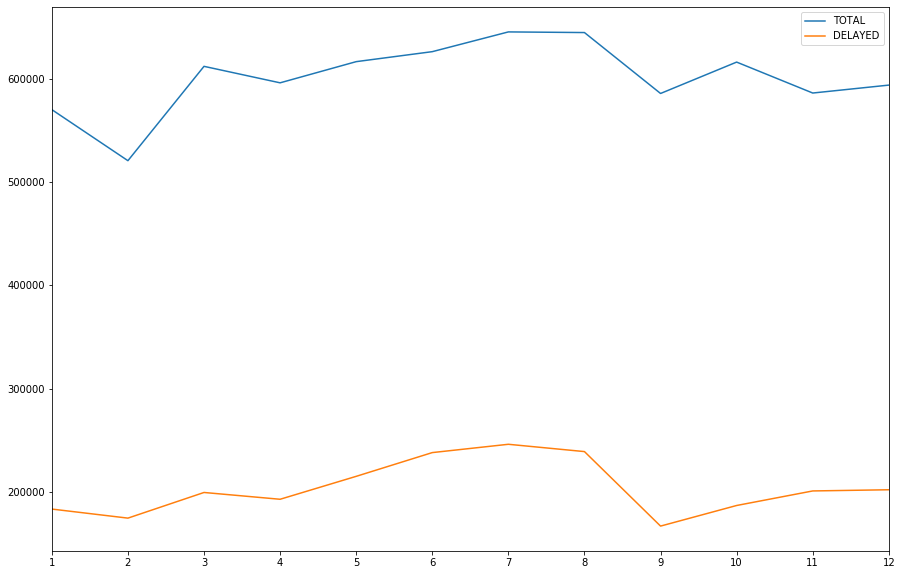

In [50]:
temporal_dist = pd.merge(monthly_fl, del_monthly_fl, left_index=True, right_index=True)
temporal_dist.rename(columns={"FL_DATE_x": "TOTAL", "FL_DATE_y": "DELAYED"}, inplace=True)
lines = temporal_dist.plot.line(figsize=(15,10))
lines.set_xticks(list(range(1,13)))

## Question 5
In this question, we aim to present which airline had the best performance in terms of mean departure delay for each possible origin and destination. In order not to repeat some procedures we did before, we use some results we found in the previous questions. 

At first, we use the `del_airl` data frame that we extracted before - it expresses the filghts that were delayed - in order to perform a `groupby` method to gather our data together. So, we create groups chracterized by `ORIGIN, DEST and CARRIER` and apply a mean calculation. 

In [51]:
orig_dest_airl = del_airl.groupby(['ORIGIN', 'DEST', 'CARRIER']).agg({'DEP_DELAY':'mean'})
orig_dest_airl.rename(columns={"DEP_DELAY": "AVG_DEP_DELAY"}, inplace=True)
orig_dest_airl.head(10)

AVG_DEP_DELAY
ORIGIN DEST CARRIER               
ABE    ATL  9E           53.771429
            DL           58.046154
            EV           40.976190
       CLT  OH           35.364706
       DTW  OO           72.098425
       FLL  G4           55.574074
       MDT  OO          175.000000
       MYR  G4           52.541667
       ORD  EV           59.066667
            OO           52.954545

Then, we set our index on the columns that we are interested in and sort them in ascending order. This means that in column `AVG_DEP_DELAY` the first cell of each group expresses the minimum average of departure delay  that this origin-destination had in 2018. In order to be more accurate, we rename each airline from its code to its full name, too.

In [52]:
orig_dest_airl.reset_index(inplace=True)
orig_dest_airl.set_index(['ORIGIN', 'DEST', 'AVG_DEP_DELAY'], inplace = True)
orig_dest_airl.sort_index(inplace=True)
orig_dest_airl['CARRIER'] = orig_dest_airl['CARRIER'].map(code_to_full_names)
orig_dest_airl.head(10)

CARRIER
ORIGIN DEST AVG_DEP_DELAY                         
ABE    ATL  40.976190      ExpressJet Airlines LLC
            53.771429            Endeavor Air Inc.
            58.046154         Delta Air Lines Inc.
       CLT  35.364706            PSA Airlines Inc.
       DTW  72.098425        SkyWest Airlines Inc.
       FLL  55.574074                Allegiant Air
       MDT  175.000000       SkyWest Airlines Inc.
       MYR  52.541667                Allegiant Air
       ORD  52.954545        SkyWest Airlines Inc.
            59.066667      ExpressJet Airlines LLC

And now we are ready to select the `first()` element of each group and find the airline that had the best performance for each possible origin-destination. We reset column AVG_DEP_DELAY from index in order to make it a distinct part of each group. 

In [53]:
orig_dest_airl.reset_index(level = 'AVG_DEP_DELAY', inplace = True)
min_del_flights = orig_dest_airl.groupby(['ORIGIN', 'DEST']).first()
min_del_flights.head(10)

AVG_DEP_DELAY                  CARRIER
ORIGIN DEST                                        
ABE    ATL       40.976190  ExpressJet Airlines LLC
       CLT       35.364706        PSA Airlines Inc.
       DTW       72.098425    SkyWest Airlines Inc.
       FLL       55.574074            Allegiant Air
       MDT      175.000000    SkyWest Airlines Inc.
       MYR       52.541667            Allegiant Air
       ORD       52.954545    SkyWest Airlines Inc.
       PGD       54.163636            Allegiant Air
       PHL       58.636364        PSA Airlines Inc.
       PIE       48.271186            Allegiant Air

At the end, based on what we found earlier, we want to find the airline that had the best performance for a given origin-destination. Thus, we create and send a query to the last data-frame we created, and get the airline's name, followed by the origin and destination given.

In [54]:
orig_dest = ['ABE', 'SFB']
min_del_flights.query('@orig_dest[0] == ORIGIN and @orig_dest[1] == DEST').CARRIER

ORIGIN  DEST
ABE     SFB     Allegiant Air
Name: CARRIER, dtype: object